In [21]:
import sys
from imp import reload
import numpy as np
import astropy.constants as ac
import matplotlib.pyplot as plt
from matplotlib import ticker
%matplotlib inline
sys.path.append('/home/wtb2/Documents/EBTEL_analysis/src/')
import ebtel_configure as ebc
import ebtel_run as ebr
reload(ebc)
reload(ebr)

<module 'ebtel_run' from '/home/wtb2/Documents/EBTEL_analysis/src/ebtel_run.py'>

# Ion Thermal Conduction Timescale versus Coulomb Collisional Coupling Timescale

The ion thermal conduction timescale can be expressed as,
$$
\tau_{i,c}=\frac{3nk_BL^2}{2\kappa_{0,i}T_i^{5/2}},
$$
where $\kappa_{0,i}\approx3.2\times10^{-8}$. Additionally, the Coulomb coupling timescale can be written as,
$$
\tau_{ei}=\frac{3m_em_i}{16e^4\sqrt{\pi}}\left(\frac{2k_BT_e}{m_e}\right)^{3/2}(n\ln{\Lambda})^{-1},
$$
where $\ln{\Lambda}\approx20$ is the Coulomb logarithm.

We can use the EBTEL-2fl model to calculate these two timescales for the case of ion heating for several impulsive heating scenarios.

First, configure the input file.

In [2]:
#Input dictionary
config_dict = {'usage_option':'dem','rad_option':'rk','dem_option':'new',
               'heat_flux_option':'limited','solver':'rka4',
               'ic_mode':'st_eq','print_plasma_params':'True'}
config_dict['output_file'] = '/home/wtb2/Documents/research_notebook/EBTEL/ebtel_data/' + 'timescale_testing'
config_dict['total_time'] = 1000
config_dict['tau'] = 1.0
config_dict['rka_error'] = 1.0e-6
config_dict['index_dem'] = 451
config_dict['sat_limit'] = 1.0
config_dict['h_back'] = 3.4e-6
config_dict['heating_shape'] = 'triangle'
config_dict['t_start_switch'] = 'uniform'
config_dict['t_end_switch'] = 'uniform'
config_dict['T0'] = 7.928e+5
config_dict['n0'] = 1.61e+8
config_dict['t_start'] = 0.0
config_dict['t_pulse_half'] = 50.0
config_dict['mean_t_start'] = 1000
config_dict['std_t_start'] = 1000

#Configure directory-level parameters
config_dict['num_events'] = 1
config_dict['heat_species'] = 'ion'
config_dict['amp_switch'] = 'uniform'
config_dict['alpha'] = -1.5
config_dict['loop_length'] = 40.0
config_dict['amp0'] = 0.05
config_dict['amp1'] = 0.5
config_dict['h_nano'] = 0.05

In [3]:
#Print input file
configurer = ebc.Configurer(config_dict,'ebtel_data/')
configurer.print_xml_config(config_file='ebtel_data/timescale_testing.xml')

Now, run the model.

In [4]:
runner = ebr.Runner('/home/wtb2/Documents/EBTEL-2fluid_repo/bin/',
                   '/home/wtb2/Documents/research_notebook/EBTEL/ebtel_data/')
runner.run_ebtel_single('timescale_testing.xml')

************************************************************************************
            Enthalpy Based Thermal Evolution of Loops (EBTEL)						
			   Two-fluid Model											
************************************************************************************

Original single-fluid code written in IDL by J.A. Klimchuk, S. Patsourakos, P.J. Cargill
See Klimchuk, J.A, S. Patsourakos & P.J. Cargill 2008, ApJ 682:1351-2362
See also Cargill, P.J., S.J. Bradshaw & J.A. Klimchuk 2012, ApJ 752:161-174

Translation into the C Programming Language by Will Barnes,
Dept. of Physics & Astronomy, Rice University (2014)
************************************************************************************

INPUTS
------
Total time: 1000 s
Time step: 1.000000 s
Loop half-length: 40.000000 Mm
Usage option(see documentation): dem
Heating pulse shape: triangle
Heating species: ion
Solving equations using adaptive fourth order Runge-Kutta routine
Using Raymond-Klimchuk Loss Function
Using limited

Get out the results.

In [5]:
results = np.loadtxt('ebtel_data/timescale_testing.txt')
time = results[:,0]
temp_e = results[:,1]
temp_i = results[:,2]
density = results[:,3]
L = config_dict['loop_length']*1e+8

Now that we have all of our results, we can make some functions to calculate the two timescales of interest to us.

In [6]:
def thermal_conduction_timescale(n,temp,L,species):
    if species is 'ion':
        kappa=3.2e-8
    elif species is 'electron':
        kappa=7.8e-7
    numer = 3.0*n*ac.k_B.cgs.value*L**2
    denom = 2.0*(kappa)*(temp)**(5.0/2.0)
    return numer/denom

def coupling_timescale(n,t_e):
    term1 = 3.0*ac.m_e.cgs.value*ac.m_p.cgs.value
    term2 = 16.0*(ac.e.gauss.value)**4*np.sqrt(np.pi)
    term3 = (2.0*ac.k_B.cgs.value*t_e/ac.m_e.cgs.value)**(3/2)
    term4 = n*20
    return term1/term2*term3/term4

Now, plot the two timescales as a function of time.

In [29]:
def tick_maker(old_ticks,n):
    if n < 2:
        raise ValueError('n must be greater than 1')
        
    n = n-1
    delta = (old_ticks[-1] - old_ticks[0])/n
    new_ticks = []
    for i in range(n):
        new_ticks.append(old_ticks[0] + i*delta)
        
    new_ticks.append(old_ticks[0] + n*delta)
    return new_ticks

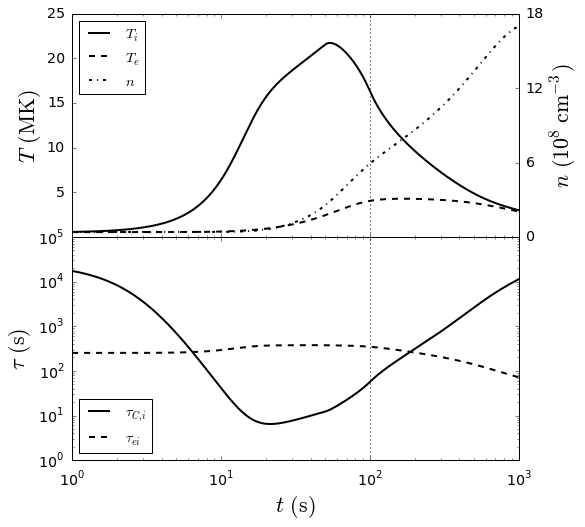

In [45]:
#fontsize
fs = 22
alfs = 0.65
#set up subplots
fig,ax = plt.subplots(2,1,figsize=(8,8),sharex=True)
plt.subplots_adjust(hspace=0)
#plot info
ti = ax[0].plot(time,temp_i/1e+6,color='black',linewidth=2,label=r'$T_i$')
te = ax[0].plot(time,temp_e/1e+6,linestyle='dashed',color='black',linewidth=2,label=r'$T_e$')
ax_n = ax[0].twinx()
dens = ax_n.plot(time,density/1e+8,linestyle='-.',color='black',linewidth=2,label=r'$n$')
ax[1].plot(time,thermal_conduction_timescale(density,temp_i,L,'ion'),
       color='black',linestyle='solid',linewidth=2,label=r'$\tau_{C,i}$')
ax[1].plot(time,coupling_timescale(density,temp_e),
       color='black',linestyle='dashed',linewidth=2,label=r'$\tau_{ei}$')
ax[0].axvline(x=100,linestyle=':',color='black')
ax[1].axvline(x=100,linestyle=':',color='black')
#limits and scale
#ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax_n.set_xscale('log')
#ax_n.set_yscale('log')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
#labels
ax[1].set_xlabel(r'$t$ $(\mathrm{s})$',fontsize=fs)
ax[0].set_ylabel(r'$T$ $(\mathrm{MK})$',fontsize=fs)
ax_n.set_ylabel(r'$n$ $(10^8 \mathrm{cm}^{-3})$',fontsize=fs)
ax[1].set_ylabel(r'$\tau$ $(\mathrm{s})$',fontsize=fs)
#legends
lines = ti + te + dens
labels = [l.get_label() for l in lines]
ax[0].legend(lines,labels,loc=2,fontsize=alfs*fs)
ax[1].legend(loc='best',fontsize=alfs*fs)
#cosmetics
ax[0].tick_params(axis='both',labelsize=alfs*fs,pad=8)
ax[1].tick_params(axis='both',labelsize=alfs*fs,pad=8)
ax_n.tick_params(axis='both',labelsize=alfs*fs,pad=8)
#
ax[0].set_yticks(tick_maker(ax[0].get_yticks(),6))
ax[0].set_yticks(ax[0].get_yticks()[1:])
ax_n.set_yticks(tick_maker(ax_n.get_yticks(),4))
#
plt.savefig('/home/wtb2/Documents/papers/hot_non-flaring_plasma_2/figures/ion_ts_compare.pdf',format='pdf',dpi=1000)
plt.show()

Now, compare this to the case of electron heating case and the electron thermal conduction timescale.

In [46]:
configurer.config_dictionary['heat_species'] = 'electron'
configurer.print_xml_config(config_file='ebtel_data/timescale_testing.xml')

In [47]:
runner.run_ebtel_single('timescale_testing.xml')

************************************************************************************
            Enthalpy Based Thermal Evolution of Loops (EBTEL)						
			   Two-fluid Model											
************************************************************************************

Original single-fluid code written in IDL by J.A. Klimchuk, S. Patsourakos, P.J. Cargill
See Klimchuk, J.A, S. Patsourakos & P.J. Cargill 2008, ApJ 682:1351-2362
See also Cargill, P.J., S.J. Bradshaw & J.A. Klimchuk 2012, ApJ 752:161-174

Translation into the C Programming Language by Will Barnes,
Dept. of Physics & Astronomy, Rice University (2014)
************************************************************************************

INPUTS
------
Total time: 1000 s
Time step: 1.000000 s
Loop half-length: 40.000000 Mm
Usage option(see documentation): dem
Heating pulse shape: triangle
Heating species: electron
Solving equations using adaptive fourth order Runge-Kutta routine
Using Raymond-Klimchuk Loss Function
Using li

In [48]:
results = np.loadtxt('ebtel_data/timescale_testing.txt')
time = results[:,0]
temp_e = results[:,1]
temp_i = results[:,2]
density = results[:,3]

Now plot the results again.

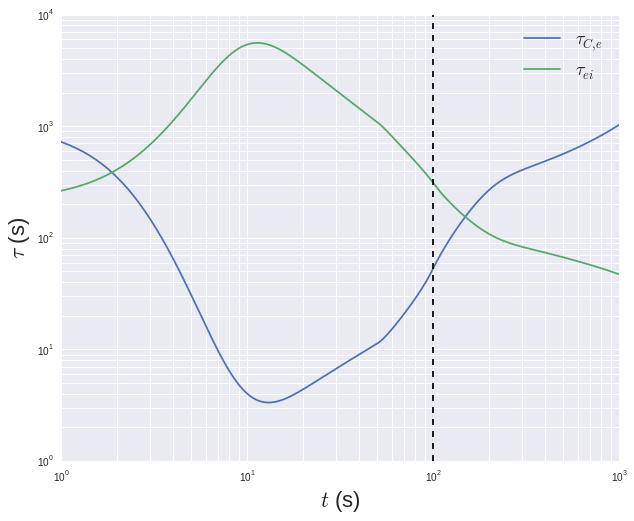

In [49]:
fig = plt.figure(figsize=(10,8))
ax = fig.gca()
ax.plot(time,thermal_conduction_timescale(density,temp_e,L,'electron'),
       label=r'$\tau_{C,e}$')
ax.plot(time,coupling_timescale(density,temp_e),
       label=r'$\tau_{ei}$')
ax.axvline(x=100,linestyle='--',color='black')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$t$ (s)',fontsize=22)
ax.set_ylabel(r'$\tau$ (s)',fontsize=22)
ax.legend(loc='best',fontsize=18)
plt.show()